In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import scipy
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna

import os
import re
import sys

from utils import load_dataset, flatten_data, select_emotions, train_test_split
from utils import Autoencoder

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# list files in dir 
path = 'models/'
files = os.listdir(path)
print(files)

# mathc files with pattern best_autoencoder_{em1}_{em2}_{excluded_human}_{human_id}.pt
pattern = r'best_autoencoder_(\d+)_(\d+)_(\d+)_(\d+).pt'
models = []
for file in files:
    match = re.match(pattern, file)
    if match:
        models.append(file)
print(len(models))


['best_autoencoder_0_1_12_10.pt', 'best_autoencoder_0_2_4_6.pt', 'best_autoencoder_2_3_4_14.pt', 'best_autoencoder_0_3_6_12.pt', 'best_autoencoder_0_3_2_6.pt', 'best_autoencoder_2_3_11_9.pt', 'best_autoencoder_1_3_7_8.pt', 'best_autoencoder_1_2_9_2.pt', 'best_autoencoder_2_3_2_1.pt', 'best_autoencoder_1_3_14_2.pt', 'best_autoencoder_2_3_4_5.pt', 'best_autoencoder_1_2_12_6.pt', 'best_autoencoder_2_3_11_10.pt', 'best_autoencoder_2_3_7_11.pt', 'best_autoencoder_0_2_6_3.pt', 'best_autoencoder_0_3_13_9.pt', 'best_autoencoder_0_3_10_5.pt', 'best_autoencoder_1_2_9_13.pt', 'best_autoencoder_0_3_6_7.pt', 'best_autoencoder_0_1_3_0.pt', 'best_autoencoder_1_3_10_12.pt', 'best_autoencoder_2_3_2_8.pt', 'best_autoencoder_0_2_8_3.pt', 'best_autoencoder_2_3_14_8.pt', 'best_autoencoder_2_3_2_11.pt', 'best_autoencoder_2_3_14_6.pt', 'best_autoencoder_0_2_5_3.pt', 'best_autoencoder_1_3_11_10.pt', 'best_autoencoder_0_2_1_5.pt', 'best_autoencoder_0_3_0_7.pt', 'best_autoencoder_0_3_8_7.pt', 'best_autoencoder_

In [89]:
def process_model(em1, em2, excluded_human):
    # load data
    data, labels, groups = load_dataset("all_features_4sec_epoch.npy")
    data, labels, groups = flatten_data(data, labels, groups)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data, labels, groups = select_emotions(data, labels, groups, em1, em2)
    train_data, train_labels, test_data, test_labels = train_test_split(data, labels, groups, excluded_human)

    # load models
    input_dim = data.shape[1]
    encoding_dim = 128  # Set the desired encoding dimension

    # Initialize the autoencoder
    models_path = [f'models/best_autoencoder_{em1}_{em2}_{excluded_human}_{human_id}.pt' for human_id in range(15) if human_id != excluded_human]
    models = []
    tensor_data= torch.tensor(test_data, dtype=torch.float)
    for model_path in models_path:
        autoencoder = Autoencoder(input_dim, encoding_dim)
        autoencoder.load_state_dict(torch.load(model_path))
        autoencoder.eval()
        models.append(autoencoder)
    
    with torch.no_grad():
        out = [model(tensor_data)[1] for model in models]
    out = np.array(out)[:, :, 0] > 0.5
    accs = [accuracy_score(test_labels, o) for o in out]
    out = np.mean(out, axis=0)
    out = np.array(out) > 0.5
    acc = accuracy_score(test_labels, out)
    accs = np.array(accs)
    return accs, acc, out

label_names = ['Neutral', 'Sad', 'Fear', 'Happy']

results = np.zeros((4, 4, 4))


outs = []
out_accs = []
out_accs_ansanble = []
for em1 in range(0, 4):
    for em2 in range(em1+1, 4):
        acc_ansambles = []
        accs_all = []
        outs.append(np.zeros((15, 360)))
        out_accs.append(np.zeros((15, 14)))
        out_accs_ansanble.append(np.zeros(15))
        for excluded_human in range(15):
            accs, acc_ansamble, out = process_model(em1, em2, excluded_human)
            outs[-1][excluded_human] = out
            mean = np.mean(accs)
            std = np.std(accs)
            accs_all.append(mean)
            acc_ansambles.append(acc_ansamble)
            out_accs[-1][excluded_human] = accs
            out_accs_ansanble[-1][excluded_human] = acc_ansamble
            results[em1, em2, 0] = np.mean(accs_all)
            results[em1, em2, 1] = np.std(accs_all)
            results[em1, em2, 2] = np.mean(acc_ansambles)
            results[em1, em2, 3] = np.std(acc_ansambles)
            
            # print(f"Emotions: {em1} {em2}, excluded human: {excluded_human}, mean acc: {mean}, std acc: {std}, ansamble acc: {acc_ansamble}")
        print(f"Emotions {label_names[em1]} {label_names[em2]}, mean acc: {np.mean(accs_all)}, std acc: {np.std(accs_all)}, ansamble acc: {np.mean(acc_ansambles)}, std ansamble acc: {np.std(acc_ansambles)}")

Emotions Neutral Sad, mean acc: 0.6138492063492064, std acc: 0.03837086138302585, ansamble acc: 0.6737037037037036, std ansamble acc: 0.06496173823753681
Emotions Neutral Fear, mean acc: 0.8396428571428572, std acc: 0.09392743979039472, ansamble acc: 0.9118518518518518, std ansamble acc: 0.1118607428401569
Emotions Neutral Happy, mean acc: 0.5899470899470901, std acc: 0.03750470048832495, ansamble acc: 0.6581481481481483, std ansamble acc: 0.0583771146695927
Emotions Sad Fear, mean acc: 0.6543518518518517, std acc: 0.06272793603121149, ansamble acc: 0.726111111111111, std ansamble acc: 0.09618654714590733
Emotions Sad Happy, mean acc: 0.49706349206349204, std acc: 0.01977863128429191, ansamble acc: 0.49611111111111106, std ansamble acc: 0.024695678634325414
Emotions Fear Happy, mean acc: 0.462962962962963, std acc: 0.023266590406952996, ansamble acc: 0.4553703703703703, std ansamble acc: 0.031006216465954167


In [58]:


labels_array = ["Neutral-Sad", "Neutral-Fear", "Neutral-Happy", "Sad-Fear", "Sad-Happy", "Fear-Happy"]
values = np.array((results[0, 1], results[0, 2], results[0, 3], results[1, 2], results[1, 3], results[2, 3]))
errors = np.array((results[0, 1], results[0, 3], results[0, 3], results[1, 3], results[1, 3], results[2, 3]))
np.save('label_array.npy', labels_array)
np.save('values.npy', values)
np.save('errors.npy', errors)


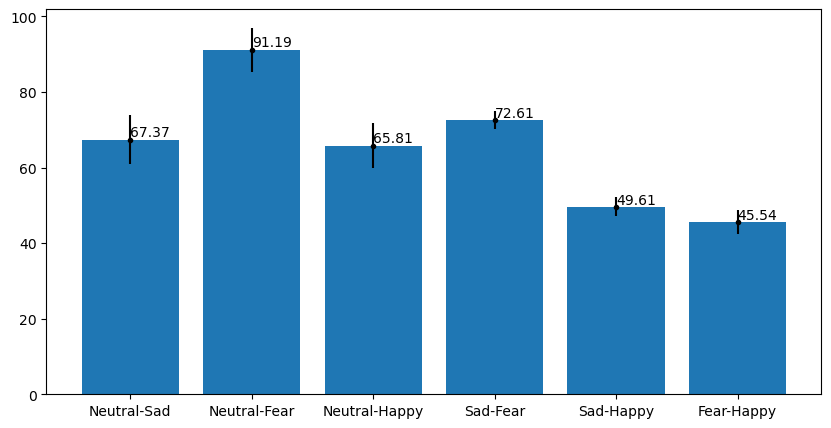

In [59]:

labels_array = np.load('label_array.npy')
values = np.load('values.npy')
errors = np.load('errors.npy')

values = values[:, 2] * 100
errors = errors[:, 3] * 100

plt.figure(figsize=(10, 5))
bars = plt.errorbar(labels_array, values, yerr=errors,fmt='.k')
bars = plt.bar(labels_array, values)


# Adding the numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='left', va='bottom')

plt.show()

(6, 15, 14)
(6, 15)


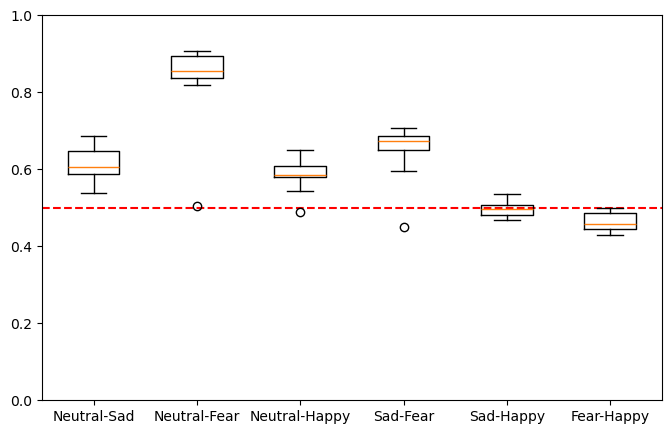

In [85]:
# genereate box plot from outs\
out_accs = np.array(out_accs)
copy_outs = out_accs.copy()
print(copy_outs.shape)
copy_outs = np.mean(copy_outs, axis=-1)
print(copy_outs.shape)
box_color = '#fcd0db'
median_color = '#fcbecf'

label_names = ['Neutral-Sad', 'Neutral-Fear', 'Neutral-Happy', 'Sad-Fear', 'Sad-Happy', 'Fear-Happy']
plt.figure(figsize=(8, 5))
plt.ylim(0, 1)
plt.hlines(0.5, 0.5, 6.5, color='r', linestyles='dashed')
plt.boxplot(copy_outs.T, labels=label_names)
plt.show()

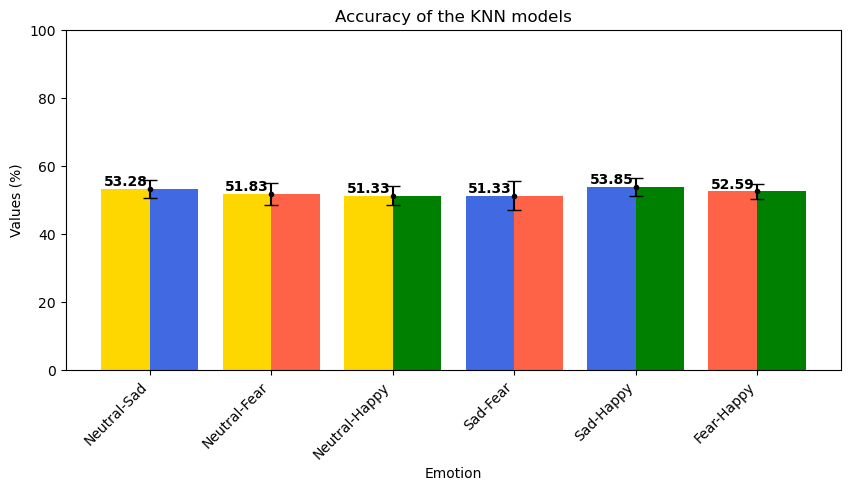

In [8]:
import numpy as np
import matplotlib

labels_array = np.load('label_array.npy')
values = np.load('values.npy')
errors = np.load('errors.npy')

values = values * 100
errors = errors * 100

# Define the custom color combinations
color_combinations = [
    ('#FFD700', '#4169E1'),  # first bar: half yellow, half blue
    ('#FFD700', '#FF6347'),  # second bar: half yellow, half red
    ('#FFD700', '#008000'),  # third bar: half yellow, half green
    ('#4169E1', '#FF6347'),  # fourth bar: half blue, half red
    ('#4169E1', '#008000'),  # fifth bar: half blue, half green
    ('#FF6347', '#008000')   # sixth bar: half red, half green
]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Create the bars
for i, label in enumerate(labels_array):
    if i < len(color_combinations):
        left_color, right_color = color_combinations[i]
        ax.bar(label, values[i], color=left_color, width=0.4, label=label + ' (left)')
        ax.bar(i + 0.4, values[i], color=right_color, width=0.4, label=label + ' (right)')
    else:
        ax.bar(i, values[i], color='#4169E1', label=label)

# Add error bars
for i, bar in enumerate(ax.containers):
 if i < len(values):
    ax.errorbar(i + 0.2, values[i], yerr=errors[i], fmt='.k', capsize=5)

# Add data labels
for i, bar in enumerate(ax.containers):
        if type(bar) != matplotlib.container.BarContainer or i % 2 != 0:
            continue
        for rect in bar:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='black', fontweight='bold')
ax.set_ylim(0, 100)
# Customize the x-axis
ax.set_xticks(np.array(range(len(labels_array))) + 0.2)
ax.set_xticklabels(labels_array, rotation=45, ha='right')

# Add a title and axis labels
ax.set_title('Accuracy of the KNN models')
ax.set_xlabel('Emotion')
ax.set_ylabel('Values (%)')


# Adjust the layout
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.savefig('accs.png')

(6,)


ValueError: Dimensions of labels and X must be compatible

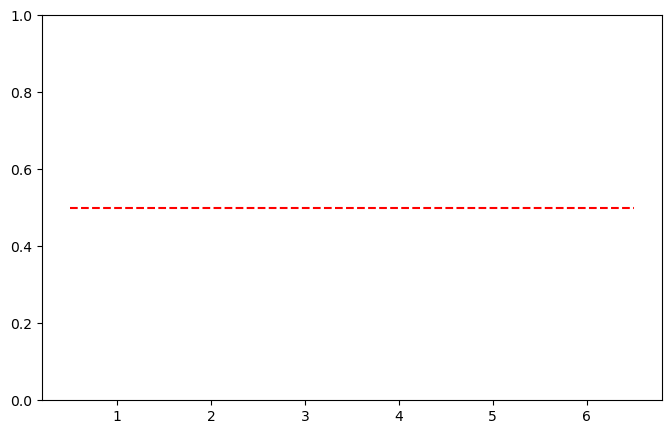

In [88]:
out_accs_ansanble = np.array(out_accs_ansanble)
copy_outs = out_accs_ansanble.copy()
print(copy_outs.shape)
box_color = '#fcd0db'
median_color = '#fcbecf'

label_names = ['Neutral-Sad', 'Neutral-Fear', 'Neutral-Happy', 'Sad-Fear', 'Sad-Happy', 'Fear-Happy']
plt.figure(figsize=(8, 5))
plt.ylim(0, 1)
plt.hlines(0.5, 0.5, 6.5, color='r', linestyles='dashed')
plt.boxplot(copy_outs.T, labels=label_names)
plt.show()

Excluded human: 0


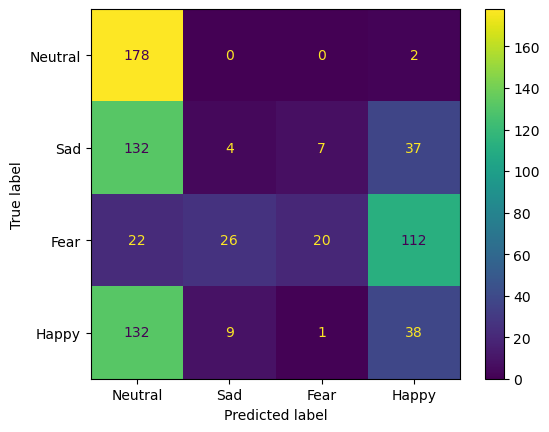

0.3333333333333333
Excluded human: 1


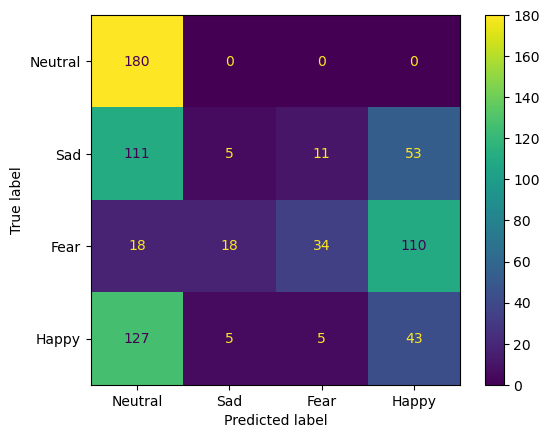

0.3638888888888889
Excluded human: 2


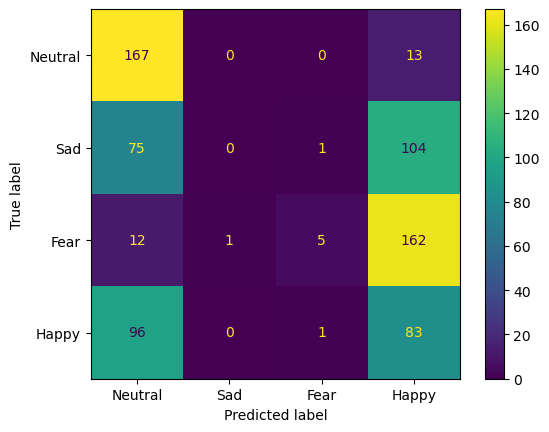

0.3541666666666667
Excluded human: 3


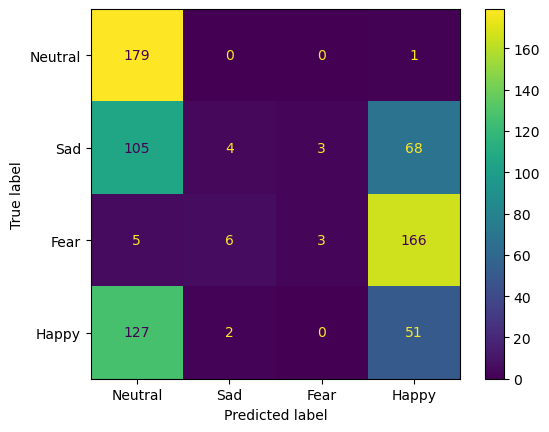

0.32916666666666666
Excluded human: 4


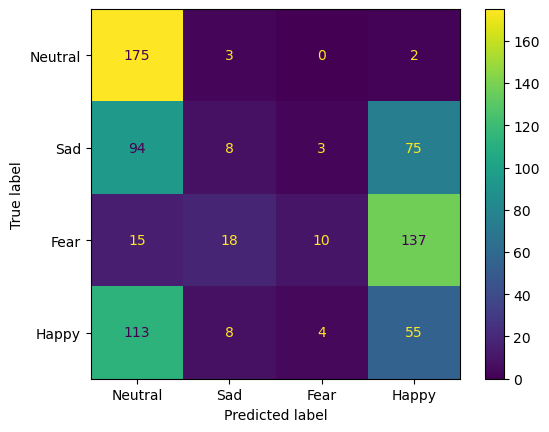

0.34444444444444444
Excluded human: 5


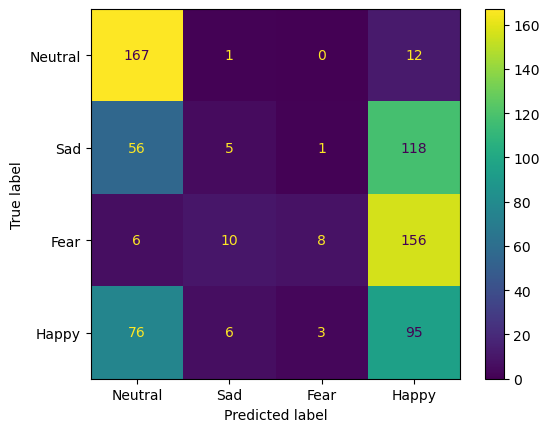

0.3819444444444444
Excluded human: 6


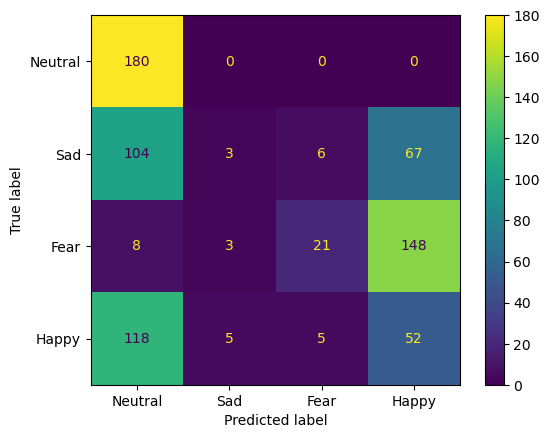

0.35555555555555557
Excluded human: 7


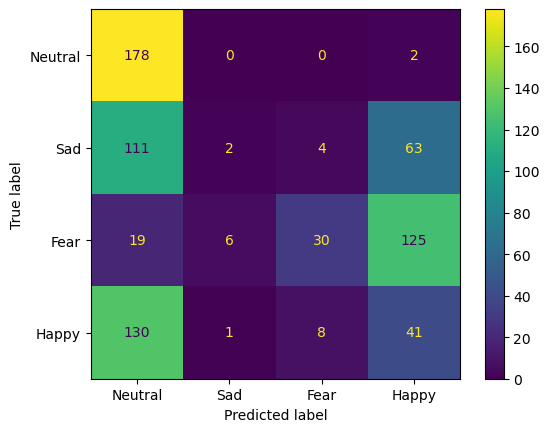

0.3486111111111111
Excluded human: 8


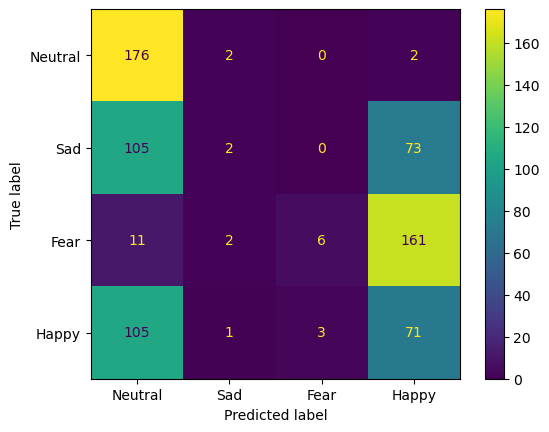

0.3541666666666667
Excluded human: 9


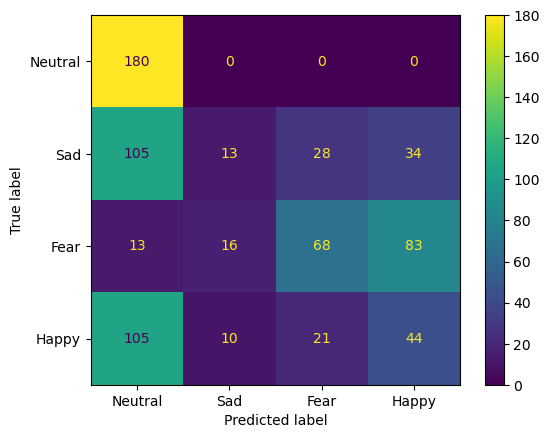

0.4236111111111111
Excluded human: 10


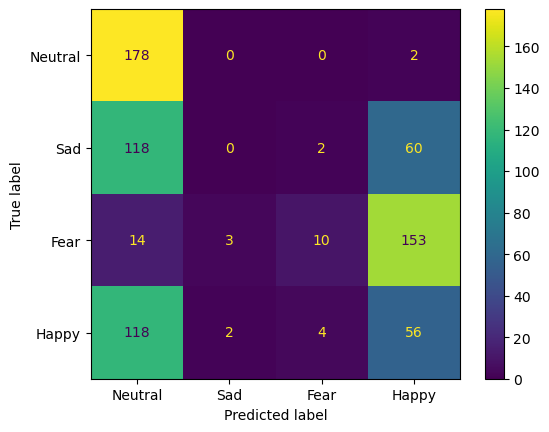

0.3388888888888889
Excluded human: 11


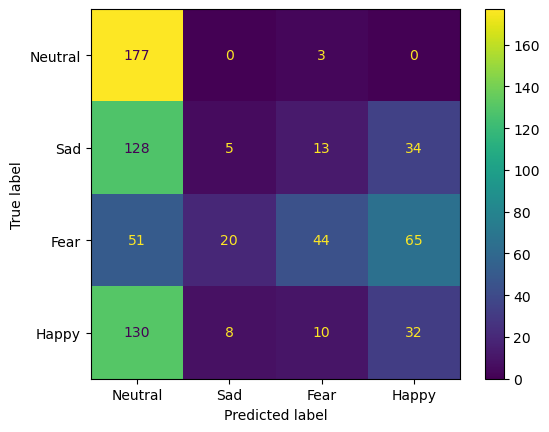

0.35833333333333334
Excluded human: 12


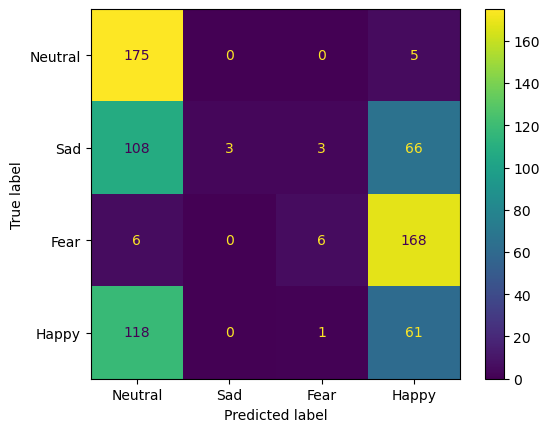

0.3402777777777778
Excluded human: 13


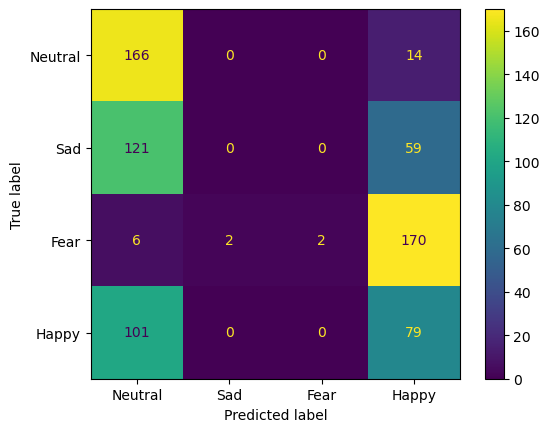

0.34305555555555556
Excluded human: 14


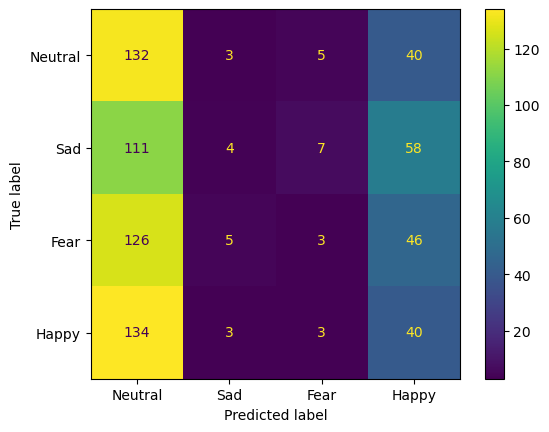

0.24861111111111112


In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def process_every_emotion(excluded_human):
    # load data
    data, labels, groups = load_dataset("all_features_4sec_epoch.npy")
    data, labels, groups = flatten_data(data, labels, groups)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    train_data, train_labels, test_data, test_labels = train_test_split(data, labels, groups, excluded_human)
    one_hot_test_labels = torch.nn.functional.one_hot(torch.tensor(test_labels.astype(int)), num_classes=4).float()
    one_hot_voting = torch.zeros_like(one_hot_test_labels)
    
    for  em1 in range(0, 4):
        for em2 in range(em1+1, 4):
            # load models
            input_dim = data.shape[1]
            encoding_dim = 128
            torch_test_data = torch.tensor(test_data, dtype=torch.float)
            models_paths = [f'models/best_autoencoder_{em1}_{em2}_{excluded_human}_{human_id}.pt' for human_id in range(15) if human_id != excluded_human]
            models = [Autoencoder(input_dim, encoding_dim) for _ in range(14)]
            for model, model_path in zip(models, models_paths):
                model.load_state_dict(torch.load(model_path))
                model.eval()
            with torch.no_grad():
                out = [model(torch_test_data)[1] for model in models]
            out = np.array(out)[:, :, 0] > 0.5
            out = np.mean(out, axis=0)
            out = np.array(out) > 0.5
            one_hot_voting[:, em1] += out == 0
            one_hot_voting[:, em2] += out == 1
    
    out = one_hot_voting.argmax(1)
    acc = accuracy_score(test_labels, out)
    cm = confusion_matrix(test_labels, out)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot()
    plt.show()
    print(acc)
    return out

for excluded_human in range(15):
    print(f"Excluded human: {excluded_human}")
    process_every_emotion(excluded_human)
